In [1]:
#20 라이브러리 호출
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models #사전 학습된 모델을 이용하고자 할 때 사용하는 라이브러리
from torchvision import transforms, datasets

import matplotlib
import matplotlib.pyplot as plt
import time
import argparse
from tqdm import tqdm
matplotlib.style.use('ggplot') #출력그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 하는 스타일
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
#21 데이터셋 전처리
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                        std=[0.229,0.224,0.225])
    ])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                        std = [0.229,0.224,0.225])
])

In [4]:
#22 데이터셋 가져오기
train_dataset = datasets.ImageFolder(
    root=r'/content/drive/MyDrive/Colab Notebooks/archive/train',
    transform = train_transform
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True,
)
val_dataset = datasets.ImageFolder(
    root=r'/content/drive/MyDrive/Colab Notebooks/archive/test',
    transform = val_transform
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False,
)

In [5]:
#23 모델 생성
def resnet50(pretrained=True, requires_grad=False):
    model = models.resnet50(progress=True, pretrained=pretrained)
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    elif requires_grad == True :
        for param in model.parameters():
            param.requires_grad = True
    model.fc = nn.Linear(2048,2) #마지막 분류를 위한 계층은 학습을 진행
    return model

In [6]:
#24 학습률 감소
class LRScheduler():
    def __init__(
        self, optimizer, patience=5, min_lr=1e-6, factor=0.5
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode = 'min',
            patience = self.patience,
            factor=self.factor,
            min_lr = self.min_lr,
            verbose = True
        )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss) #학습률 업데이트/ 오차를 받아서 이전 오차와 비교했을 때 차이가 없으면 학습률을 업데이트

In [7]:
#25 조기종료
class EarlyStopping():
    def __init__(self, patience=5, verbose=False, delta=0, path='../data/checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    def save_checkpoint(self, val_loss, model): #검증데이터셋에 대한 오차가 감소하면 모델을 저장
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model...')
        torch.save(model.sate_dict(), self.path) #지정된 경로에 모델 저장
        self.val_loss_min = val_loss

In [8]:
#26 인수값 지정
parser = argparse.ArgumentParser() #인수값을 받을 수 있는 인스턴스 생성
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true')

_StoreTrueAction(option_strings=['--early-stopping'], dest='early_stopping', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [9]:
import argparse
args = parser.parse_args('')

In [10]:
#27 사전훈련된 모델의 파라미터 확인
print(f'Computation device: {device}\n')
model = models.resnet50(pretrained = True).to(device) #사전훈련된 Resnet 50 사용
total_params = sum(p.numel() for p in model.parameters()) # 총 파라미터 수
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad) #학습가능한 파라미터 수
print(f"{total_trainable_params:,} training parameters.")

Computation device: cuda:0



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 262MB/s]


25,557,032 total parameters.
25,557,032 training parameters.


In [11]:
#28 옵티마이저의 손실함수 지정
lr = 0.001
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [12]:
#29 오차, 정확도 및 모델의 이용에 대한 문자열
loss_plot_name = 'loss' #오차 출력에 대한 문자열
acc_plot_name = 'accuracy' #정확도 출력에 대한 문자열
model_name = 'model' #모델을 저장하기 위한 문자열

In [13]:
#30 오차, 정확도 및 모델의 이름에 대한 문자열
if args.lr_scheduler:
    print('INFO: Initializing learning rate scheduler')
    lr_scheduler = LRScheduler(optimizer)
    loss_plot_name = 'lrs_loss'
    acc_plot_name = 'lrs_accuracy'
    model_name = 'lrs_model'
if args.early_stopping:
    print('INFO: Initializing early saopping')
    early_stopping = EarlyStopping()
    loss_plot_name = 'es_loss' #조기종료를 적용했을 때의 오차에 대한 문자열
    acc_plot_name = 'es_accuracy' #조기종료를 적용했을 때의 정확도에 대한 문자열
    model_name = 'es_model' #조기종료를 적용했을때의 모델에 대한문자열


In [17]:
#31 모델 학습 함수
def training(model, train_dataloader, train_dataset, optimizer, criterion):
    print("Training")
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size)) #훈련 진행 과정을 시각화로 표현
    for i, data in prog_bar :
        counter += 1
        data, target = data[0].to(device), data[1].to(device)
        total += target.size(0)
        optimizer.zero_grad()
        outputs=model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / counter
    train_accuracy = 100. *train_running_correct / total
    return train_loss, train_accuracy

In [18]:
#32 모델검증함수
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size)) #모델검증 과정 시각화
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target  = data[0].to(device), data[1].to(device)
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)

            val_running_loss += loss.item()
            _,preds = torch.max(outputs.data,1)
            val_running_correct += (preds==target).sum().item()

        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [21]:
#33 모델학습
train_loss, train_accuracy = [],[]
val_loss, val_accuracy = [], []

start = time.time()
for epoch in range(epochs) :
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = training(model, train_dataloader, train_dataset, optimizer, criterion)
    val_epoch_loss, val_epoch_accuracy = validate(model, val_dataloader, val_dataset, criterion)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if args.lr_scheduler : #인수 값이 lr_scheduler이면 다음을 실행
        lr_scheduler(val_epoch_loss, model)
        if early_stopping.early_stop:
            break
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}")
end=time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch 1 of 100
Training


16it [00:05,  3.14it/s]


Validating


8it [00:02,  3.28it/s]


Train Loss: 0.3780, Train Acc: 83.53
Val Loss: 0.6585, Val Acc: 66.80
Epoch 2 of 100
Training


16it [00:04,  3.31it/s]


Validating


8it [00:02,  3.62it/s]


Train Loss: 0.3519, Train Acc: 85.74
Val Loss: 0.7065, Val Acc: 70.36
Epoch 3 of 100
Training


16it [00:05,  3.00it/s]


Validating


8it [00:02,  2.69it/s]


Train Loss: 0.3177, Train Acc: 87.35
Val Loss: 0.4695, Val Acc: 78.66
Epoch 4 of 100
Training


16it [00:04,  3.27it/s]


Validating


8it [00:02,  3.77it/s]


Train Loss: 0.2632, Train Acc: 89.36
Val Loss: 0.5486, Val Acc: 75.89
Epoch 5 of 100
Training


16it [00:05,  2.95it/s]


Validating


8it [00:02,  3.69it/s]


Train Loss: 0.2419, Train Acc: 90.56
Val Loss: 0.6300, Val Acc: 74.70
Epoch 6 of 100
Training


16it [00:04,  3.28it/s]


Validating


8it [00:02,  3.43it/s]


Train Loss: 0.2624, Train Acc: 88.55
Val Loss: 1.3120, Val Acc: 63.64
Epoch 7 of 100
Training


16it [00:05,  3.03it/s]


Validating


8it [00:02,  3.76it/s]


Train Loss: 0.2450, Train Acc: 89.76
Val Loss: 0.3711, Val Acc: 83.79
Epoch 8 of 100
Training


16it [00:05,  3.11it/s]


Validating


8it [00:03,  2.60it/s]


Train Loss: 0.1918, Train Acc: 91.77
Val Loss: 0.9385, Val Acc: 69.57
Epoch 9 of 100
Training


16it [00:04,  3.21it/s]


Validating


8it [00:02,  3.67it/s]


Train Loss: 0.1847, Train Acc: 93.37
Val Loss: 1.1297, Val Acc: 68.38
Epoch 10 of 100
Training


16it [00:05,  3.15it/s]


Validating


8it [00:02,  3.05it/s]


Train Loss: 0.1288, Train Acc: 95.58
Val Loss: 0.2439, Val Acc: 88.93
Epoch 11 of 100
Training


16it [00:04,  3.29it/s]


Validating


8it [00:02,  3.76it/s]


Train Loss: 0.1494, Train Acc: 93.78
Val Loss: 0.3982, Val Acc: 88.14
Epoch 12 of 100
Training


16it [00:05,  3.05it/s]


Validating


8it [00:02,  3.57it/s]


Train Loss: 0.2349, Train Acc: 91.37
Val Loss: 0.8547, Val Acc: 74.70
Epoch 13 of 100
Training


16it [00:04,  3.32it/s]


Validating


8it [00:02,  3.73it/s]


Train Loss: 0.1795, Train Acc: 93.17
Val Loss: 0.5031, Val Acc: 84.98
Epoch 14 of 100
Training


16it [00:05,  2.96it/s]


Validating


8it [00:02,  3.81it/s]


Train Loss: 0.1166, Train Acc: 95.38
Val Loss: 0.9470, Val Acc: 65.61
Epoch 15 of 100
Training


16it [00:04,  3.30it/s]


Validating


8it [00:02,  3.74it/s]


Train Loss: 0.1483, Train Acc: 94.78
Val Loss: 1.6977, Val Acc: 43.87
Epoch 16 of 100
Training


16it [00:05,  2.92it/s]


Validating


8it [00:02,  3.77it/s]


Train Loss: 0.2948, Train Acc: 87.75
Val Loss: 1.0633, Val Acc: 73.52
Epoch 17 of 100
Training


16it [00:04,  3.29it/s]


Validating


8it [00:02,  3.56it/s]


Train Loss: 0.1747, Train Acc: 93.37
Val Loss: 0.2767, Val Acc: 91.70
Epoch 18 of 100
Training


16it [00:05,  3.00it/s]


Validating


8it [00:02,  3.86it/s]


Train Loss: 0.1176, Train Acc: 96.39
Val Loss: 0.4433, Val Acc: 88.93
Epoch 19 of 100
Training


16it [00:04,  3.31it/s]


Validating


8it [00:02,  3.16it/s]


Train Loss: 0.1546, Train Acc: 93.98
Val Loss: 0.7259, Val Acc: 76.28
Epoch 20 of 100
Training


16it [00:05,  3.15it/s]


Validating


8it [00:02,  3.79it/s]


Train Loss: 0.1223, Train Acc: 95.38
Val Loss: 2.1350, Val Acc: 45.45
Epoch 21 of 100
Training


16it [00:04,  3.33it/s]


Validating


8it [00:02,  2.98it/s]


Train Loss: 0.1678, Train Acc: 93.57
Val Loss: 0.4773, Val Acc: 85.77
Epoch 22 of 100
Training


16it [00:04,  3.28it/s]


Validating


8it [00:02,  3.74it/s]


Train Loss: 0.1547, Train Acc: 94.78
Val Loss: 1.5034, Val Acc: 60.87
Epoch 23 of 100
Training


16it [00:05,  3.14it/s]


Validating


8it [00:02,  3.23it/s]


Train Loss: 0.1246, Train Acc: 95.58
Val Loss: 1.6270, Val Acc: 62.85
Epoch 24 of 100
Training


16it [00:04,  3.30it/s]


Validating


8it [00:02,  3.73it/s]


Train Loss: 0.0640, Train Acc: 96.79
Val Loss: 0.3547, Val Acc: 86.96
Epoch 25 of 100
Training


16it [00:05,  3.06it/s]


Validating


8it [00:02,  3.62it/s]


Train Loss: 0.0990, Train Acc: 96.59
Val Loss: 0.5755, Val Acc: 78.26
Epoch 26 of 100
Training


16it [00:04,  3.30it/s]


Validating


8it [00:02,  3.79it/s]


Train Loss: 0.1051, Train Acc: 95.78
Val Loss: 0.7860, Val Acc: 77.87
Epoch 27 of 100
Training


16it [00:05,  2.97it/s]


Validating


8it [00:02,  3.83it/s]


Train Loss: 0.1059, Train Acc: 95.78
Val Loss: 0.9884, Val Acc: 72.33
Epoch 28 of 100
Training


16it [00:04,  3.31it/s]


Validating


8it [00:02,  3.75it/s]


Train Loss: 0.0826, Train Acc: 96.79
Val Loss: 0.4620, Val Acc: 88.54
Epoch 29 of 100
Training


16it [00:05,  2.93it/s]


Validating


8it [00:02,  3.77it/s]


Train Loss: 0.0835, Train Acc: 97.19
Val Loss: 1.1760, Val Acc: 66.40
Epoch 30 of 100
Training


16it [00:04,  3.31it/s]


Validating


8it [00:02,  3.59it/s]


Train Loss: 0.0965, Train Acc: 95.98
Val Loss: 2.0313, Val Acc: 56.92
Epoch 31 of 100
Training


16it [00:05,  3.03it/s]


Validating


8it [00:02,  3.71it/s]


Train Loss: 0.1710, Train Acc: 93.78
Val Loss: 0.5412, Val Acc: 86.56
Epoch 32 of 100
Training


16it [00:04,  3.32it/s]


Validating


8it [00:02,  3.27it/s]


Train Loss: 0.1652, Train Acc: 93.17
Val Loss: 1.1611, Val Acc: 58.89
Epoch 33 of 100
Training


16it [00:05,  3.15it/s]


Validating


8it [00:02,  3.80it/s]


Train Loss: 0.1376, Train Acc: 94.98
Val Loss: 0.9022, Val Acc: 81.42
Epoch 34 of 100
Training


16it [00:04,  3.30it/s]


Validating


8it [00:02,  3.02it/s]


Train Loss: 0.1036, Train Acc: 96.39
Val Loss: 0.7266, Val Acc: 76.68
Epoch 35 of 100
Training


16it [00:04,  3.26it/s]


Validating


8it [00:02,  3.79it/s]


Train Loss: 0.0765, Train Acc: 97.39
Val Loss: 1.3839, Val Acc: 66.01
Epoch 36 of 100
Training


16it [00:04,  3.20it/s]


Validating


8it [00:02,  3.15it/s]


Train Loss: 0.1346, Train Acc: 95.58
Val Loss: 1.2790, Val Acc: 62.85
Epoch 37 of 100
Training


16it [00:04,  3.32it/s]


Validating


8it [00:02,  3.76it/s]


Train Loss: 0.1583, Train Acc: 93.37
Val Loss: 0.4979, Val Acc: 86.96
Epoch 38 of 100
Training


16it [00:05,  3.08it/s]


Validating


8it [00:02,  3.50it/s]


Train Loss: 0.0852, Train Acc: 96.99
Val Loss: 1.1256, Val Acc: 73.91
Epoch 39 of 100
Training


16it [00:04,  3.32it/s]


Validating


8it [00:02,  3.77it/s]


Train Loss: 0.0471, Train Acc: 98.19
Val Loss: 0.7417, Val Acc: 81.42
Epoch 40 of 100
Training


16it [00:05,  2.94it/s]


Validating


8it [00:02,  3.85it/s]


Train Loss: 0.0577, Train Acc: 98.39
Val Loss: 1.0153, Val Acc: 74.70
Epoch 41 of 100
Training


16it [00:04,  3.32it/s]


Validating


8it [00:02,  3.73it/s]


Train Loss: 0.0495, Train Acc: 97.59
Val Loss: 1.3814, Val Acc: 63.24
Epoch 42 of 100
Training


16it [00:05,  2.93it/s]


Validating


8it [00:02,  3.75it/s]


Train Loss: 0.0471, Train Acc: 98.39
Val Loss: 0.9518, Val Acc: 73.91
Epoch 43 of 100
Training


16it [00:04,  3.33it/s]


Validating


8it [00:02,  3.64it/s]


Train Loss: 0.0340, Train Acc: 99.00
Val Loss: 0.6877, Val Acc: 80.24
Epoch 44 of 100
Training


16it [00:05,  2.99it/s]


Validating


8it [00:02,  3.80it/s]


Train Loss: 0.0735, Train Acc: 97.19
Val Loss: 0.6766, Val Acc: 81.42
Epoch 45 of 100
Training


16it [00:04,  3.34it/s]


Validating


8it [00:02,  3.30it/s]


Train Loss: 0.1026, Train Acc: 97.39
Val Loss: 0.9810, Val Acc: 79.45
Epoch 46 of 100
Training


16it [00:05,  3.12it/s]


Validating


8it [00:02,  3.82it/s]


Train Loss: 0.0651, Train Acc: 97.99
Val Loss: 0.8680, Val Acc: 75.89
Epoch 47 of 100
Training


16it [00:04,  3.32it/s]


Validating


8it [00:02,  3.07it/s]


Train Loss: 0.0974, Train Acc: 96.59
Val Loss: 0.6536, Val Acc: 81.82
Epoch 48 of 100
Training


16it [00:04,  3.22it/s]


Validating


8it [00:02,  3.75it/s]


Train Loss: 0.0489, Train Acc: 98.19
Val Loss: 1.0614, Val Acc: 75.89
Epoch 49 of 100
Training


16it [00:05,  3.20it/s]


Validating


8it [00:02,  3.12it/s]


Train Loss: 0.0504, Train Acc: 97.79
Val Loss: 0.8827, Val Acc: 74.31
Epoch 50 of 100
Training


16it [00:04,  3.32it/s]


Validating


8it [00:02,  3.67it/s]


Train Loss: 0.0254, Train Acc: 99.40
Val Loss: 1.0624, Val Acc: 74.70
Epoch 51 of 100
Training


16it [00:05,  3.04it/s]


Validating


8it [00:02,  3.42it/s]


Train Loss: 0.0445, Train Acc: 98.19
Val Loss: 1.0600, Val Acc: 77.47
Epoch 52 of 100
Training


16it [00:04,  3.30it/s]


Validating


8it [00:02,  3.73it/s]


Train Loss: 0.0839, Train Acc: 97.19
Val Loss: 0.5787, Val Acc: 88.54
Epoch 53 of 100
Training


16it [00:05,  2.94it/s]


Validating


8it [00:02,  3.78it/s]


Train Loss: 0.0859, Train Acc: 97.79
Val Loss: 1.0613, Val Acc: 79.84
Epoch 54 of 100
Training


16it [00:04,  3.32it/s]


Validating


8it [00:02,  3.77it/s]


Train Loss: 0.1060, Train Acc: 95.38
Val Loss: 0.5671, Val Acc: 84.58
Epoch 55 of 100
Training


16it [00:05,  2.97it/s]


Validating


8it [00:02,  3.82it/s]


Train Loss: 0.1093, Train Acc: 95.18
Val Loss: 1.3331, Val Acc: 66.01
Epoch 56 of 100
Training


16it [00:04,  3.32it/s]


Validating


8it [00:02,  3.61it/s]


Train Loss: 0.0797, Train Acc: 97.39
Val Loss: 2.0773, Val Acc: 58.50
Epoch 57 of 100
Training


16it [00:05,  3.00it/s]


Validating


8it [00:02,  3.70it/s]


Train Loss: 0.0839, Train Acc: 96.39
Val Loss: 1.2768, Val Acc: 73.52
Epoch 58 of 100
Training


16it [00:04,  3.32it/s]


Validating


8it [00:02,  3.27it/s]


Train Loss: 0.0896, Train Acc: 97.39
Val Loss: 1.1900, Val Acc: 73.52
Epoch 59 of 100
Training


16it [00:05,  3.12it/s]


Validating


8it [00:02,  3.77it/s]


Train Loss: 0.0870, Train Acc: 96.99
Val Loss: 1.1262, Val Acc: 73.12
Epoch 60 of 100
Training


16it [00:04,  3.30it/s]


Validating


8it [00:02,  3.06it/s]


Train Loss: 0.1014, Train Acc: 96.39
Val Loss: 3.2259, Val Acc: 41.11
Epoch 61 of 100
Training


16it [00:04,  3.22it/s]


Validating


8it [00:02,  3.76it/s]


Train Loss: 0.0907, Train Acc: 96.59
Val Loss: 0.5095, Val Acc: 80.63
Epoch 62 of 100
Training


16it [00:05,  3.18it/s]


Validating


8it [00:02,  3.21it/s]


Train Loss: 0.0723, Train Acc: 97.59
Val Loss: 0.8717, Val Acc: 79.84
Epoch 63 of 100
Training


16it [00:04,  3.33it/s]


Validating


8it [00:02,  3.75it/s]


Train Loss: 0.0658, Train Acc: 97.39
Val Loss: 1.4277, Val Acc: 72.73
Epoch 64 of 100
Training


16it [00:05,  3.07it/s]


Validating


8it [00:02,  3.42it/s]


Train Loss: 0.0618, Train Acc: 98.59
Val Loss: 1.7324, Val Acc: 62.06
Epoch 65 of 100
Training


16it [00:04,  3.32it/s]


Validating


8it [00:02,  3.83it/s]


Train Loss: 0.0846, Train Acc: 97.19
Val Loss: 0.4123, Val Acc: 88.93
Epoch 66 of 100
Training


16it [00:05,  2.96it/s]


Validating


8it [00:02,  3.71it/s]


Train Loss: 0.0934, Train Acc: 97.19
Val Loss: 1.0445, Val Acc: 74.70
Epoch 67 of 100
Training


16it [00:04,  3.33it/s]


Validating


8it [00:02,  3.71it/s]


Train Loss: 0.1057, Train Acc: 95.78
Val Loss: 1.9532, Val Acc: 62.85
Epoch 68 of 100
Training


16it [00:05,  2.94it/s]


Validating


8it [00:02,  3.77it/s]


Train Loss: 0.0653, Train Acc: 97.99
Val Loss: 1.1205, Val Acc: 69.57
Epoch 69 of 100
Training


16it [00:04,  3.34it/s]


Validating


8it [00:02,  3.63it/s]


Train Loss: 0.0979, Train Acc: 97.39
Val Loss: 0.9176, Val Acc: 76.68
Epoch 70 of 100
Training


16it [00:05,  3.01it/s]


Validating


8it [00:02,  3.83it/s]


Train Loss: 0.0456, Train Acc: 98.59
Val Loss: 0.7873, Val Acc: 72.73
Epoch 71 of 100
Training


16it [00:04,  3.33it/s]


Validating


8it [00:02,  3.22it/s]


Train Loss: 0.0386, Train Acc: 98.19
Val Loss: 0.5540, Val Acc: 84.58
Epoch 72 of 100
Training


16it [00:05,  3.06it/s]


Validating


8it [00:02,  3.84it/s]


Train Loss: 0.0656, Train Acc: 97.59
Val Loss: 1.0289, Val Acc: 76.68
Epoch 73 of 100
Training


16it [00:04,  3.33it/s]


Validating


8it [00:02,  2.99it/s]


Train Loss: 0.0679, Train Acc: 97.59
Val Loss: 1.2999, Val Acc: 71.94
Epoch 74 of 100
Training


16it [00:04,  3.25it/s]


Validating


8it [00:02,  3.60it/s]


Train Loss: 0.0599, Train Acc: 97.79
Val Loss: 1.0001, Val Acc: 71.15
Epoch 75 of 100
Training


16it [00:05,  3.17it/s]


Validating


8it [00:02,  3.19it/s]


Train Loss: 0.0354, Train Acc: 99.00
Val Loss: 1.3871, Val Acc: 67.19
Epoch 76 of 100
Training


16it [00:04,  3.31it/s]


Validating


8it [00:02,  3.62it/s]


Train Loss: 0.0332, Train Acc: 99.00
Val Loss: 2.7653, Val Acc: 48.62
Epoch 77 of 100
Training


16it [00:05,  3.03it/s]


Validating


8it [00:02,  3.44it/s]


Train Loss: 0.0533, Train Acc: 98.39
Val Loss: 0.9280, Val Acc: 77.87
Epoch 78 of 100
Training


16it [00:04,  3.28it/s]


Validating


8it [00:02,  3.42it/s]


Train Loss: 0.0763, Train Acc: 97.99
Val Loss: 1.3996, Val Acc: 64.43
Epoch 79 of 100
Training


16it [00:05,  2.74it/s]


Validating


8it [00:02,  3.73it/s]


Train Loss: 0.0439, Train Acc: 98.19
Val Loss: 1.0459, Val Acc: 74.70
Epoch 80 of 100
Training


16it [00:04,  3.33it/s]


Validating


8it [00:02,  3.77it/s]


Train Loss: 0.0290, Train Acc: 99.00
Val Loss: 0.9060, Val Acc: 79.05
Epoch 81 of 100
Training


16it [00:05,  2.94it/s]


Validating


8it [00:02,  3.78it/s]


Train Loss: 0.0161, Train Acc: 99.80
Val Loss: 1.3917, Val Acc: 68.38
Epoch 82 of 100
Training


16it [00:04,  3.32it/s]


Validating


8it [00:02,  3.38it/s]


Train Loss: 0.0345, Train Acc: 99.20
Val Loss: 0.9079, Val Acc: 81.42
Epoch 83 of 100
Training


16it [00:05,  3.08it/s]


Validating


8it [00:02,  3.78it/s]


Train Loss: 0.0357, Train Acc: 98.80
Val Loss: 1.6484, Val Acc: 73.91
Epoch 84 of 100
Training


16it [00:04,  3.33it/s]


Validating


8it [00:02,  3.00it/s]


Train Loss: 0.1087, Train Acc: 95.38
Val Loss: 0.8667, Val Acc: 79.84
Epoch 85 of 100
Training


16it [00:05,  3.19it/s]


Validating


8it [00:02,  3.82it/s]


Train Loss: 0.2034, Train Acc: 93.17
Val Loss: 1.0120, Val Acc: 79.45
Epoch 86 of 100
Training


16it [00:04,  3.23it/s]


Validating


8it [00:02,  3.12it/s]


Train Loss: 0.1427, Train Acc: 93.98
Val Loss: 0.6711, Val Acc: 77.47
Epoch 87 of 100
Training


16it [00:04,  3.33it/s]


Validating


8it [00:02,  3.78it/s]


Train Loss: 0.1217, Train Acc: 95.18
Val Loss: 0.9017, Val Acc: 73.12
Epoch 88 of 100
Training


16it [00:05,  3.13it/s]


Validating


8it [00:02,  3.35it/s]


Train Loss: 0.0778, Train Acc: 97.79
Val Loss: 1.7247, Val Acc: 58.89
Epoch 89 of 100
Training


16it [00:04,  3.32it/s]


Validating


8it [00:02,  3.74it/s]


Train Loss: 0.0638, Train Acc: 98.59
Val Loss: 1.3245, Val Acc: 72.33
Epoch 90 of 100
Training


16it [00:05,  2.99it/s]


Validating


8it [00:02,  3.78it/s]


Train Loss: 0.0616, Train Acc: 97.99
Val Loss: 0.7810, Val Acc: 80.24
Epoch 91 of 100
Training


16it [00:04,  3.33it/s]


Validating


8it [00:02,  3.77it/s]


Train Loss: 0.0505, Train Acc: 98.59
Val Loss: 1.3331, Val Acc: 70.36
Epoch 92 of 100
Training


16it [00:05,  2.96it/s]


Validating


8it [00:02,  3.77it/s]


Train Loss: 0.0427, Train Acc: 98.59
Val Loss: 1.2114, Val Acc: 73.91
Epoch 93 of 100
Training


16it [00:04,  3.31it/s]


Validating


8it [00:02,  3.74it/s]


Train Loss: 0.0306, Train Acc: 98.80
Val Loss: 1.0651, Val Acc: 73.91
Epoch 94 of 100
Training


16it [00:05,  2.97it/s]


Validating


8it [00:02,  3.71it/s]


Train Loss: 0.0345, Train Acc: 99.00
Val Loss: 0.6446, Val Acc: 81.42
Epoch 95 of 100
Training


16it [00:04,  3.31it/s]


Validating


8it [00:02,  3.41it/s]


Train Loss: 0.0466, Train Acc: 98.59
Val Loss: 0.9631, Val Acc: 75.89
Epoch 96 of 100
Training


16it [00:05,  3.04it/s]


Validating


8it [00:02,  3.78it/s]


Train Loss: 0.0516, Train Acc: 97.99
Val Loss: 1.1040, Val Acc: 74.70
Epoch 97 of 100
Training


16it [00:04,  3.32it/s]


Validating


8it [00:02,  3.11it/s]


Train Loss: 0.0377, Train Acc: 98.80
Val Loss: 1.5903, Val Acc: 68.77
Epoch 98 of 100
Training


16it [00:05,  3.18it/s]


Validating


8it [00:02,  3.75it/s]


Train Loss: 0.0268, Train Acc: 99.00
Val Loss: 0.7020, Val Acc: 81.03
Epoch 99 of 100
Training


16it [00:04,  3.22it/s]


Validating


8it [00:02,  3.07it/s]


Train Loss: 0.0305, Train Acc: 99.20
Val Loss: 1.0371, Val Acc: 78.26
Epoch 100 of 100
Training


16it [00:04,  3.33it/s]


Validating


8it [00:02,  3.85it/s]

Train Loss: 0.0248, Train Acc: 98.80
Val Loss: 1.1974, Val Acc: 67.59
Training time: 12.237 minutes


Saving loss and accuracy plots ...


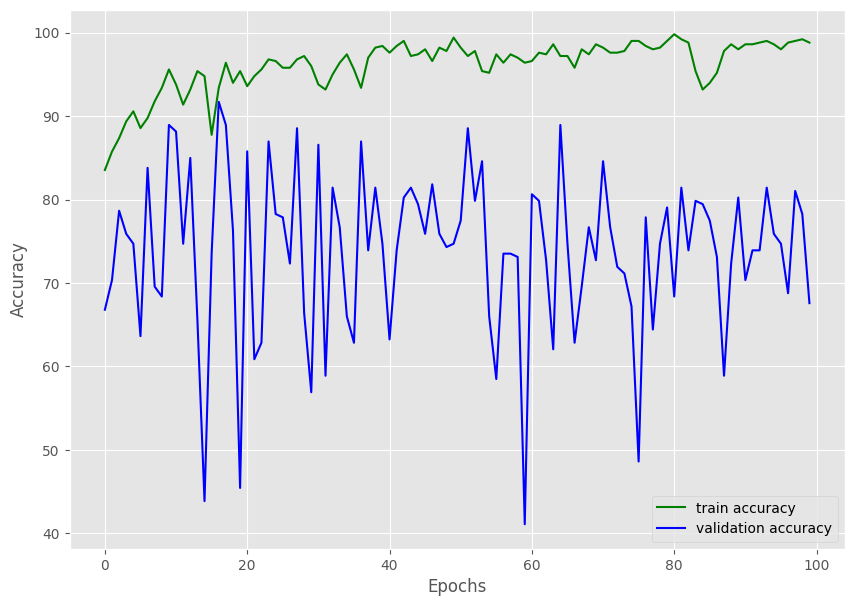

TRANING COMPLETE


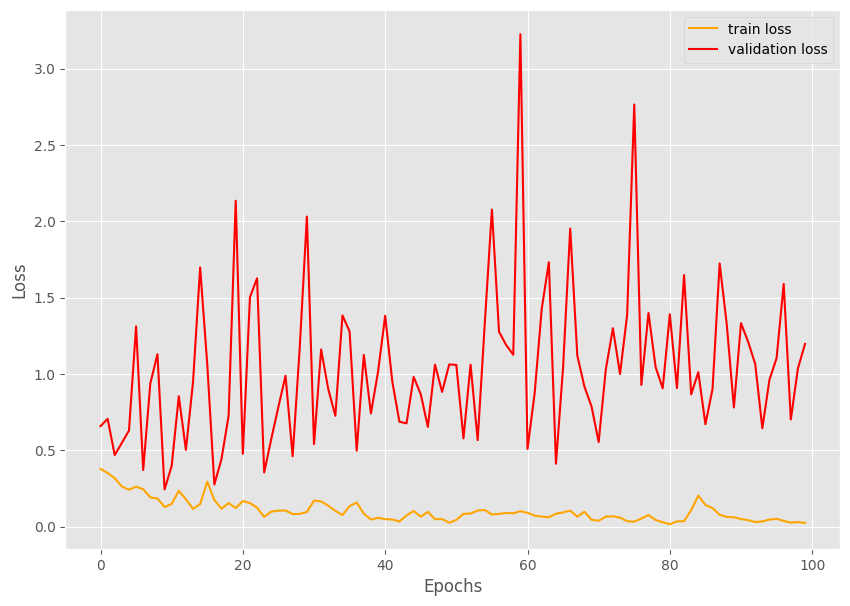

In [25]:
#34 모델학습 결과 출력
print('Saving loss and accuracy plots ...')
plt.figure(figsize=(10,7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/archive/{acc_plot_name}.png")
plt.show()
plt.figure(figsize=(10,7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/archive/{model_name}.pdf") #모델을 저장
print("TRANING COMPLETE")